In [24]:
# 03_gen_with_soundfont_model3.ipynb
# Generación y audio para el Modelo 3 + métricas y diagnósticos

import sys, importlib, subprocess

# Requisitos de audio (solo la primera vez)
for pkg in ["pretty_midi", "soundfile", "pyfluidsynth"]:
    try:
        importlib.import_module("pretty_midi" if pkg=="pretty_midi" else pkg)
    except Exception:
        print(f"[INFO] instalando {pkg} …")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", pkg])

print("[OK] dependencias listas")


[INFO] instalando pyfluidsynth …
[OK] dependencias listas


In [25]:
import os, json, time, math, glob
import numpy as np
import pathlib as P
from typing import Dict, Any, Tuple, Optional

def find_project_root(start: P.Path) -> P.Path:
    cur = start.resolve()
    for _ in range(7):
        if (cur / "models" / "final").exists() and (cur / "data").exists():
            return cur
        if cur.parent == cur: break
        cur = cur.parent
    return start.resolve()

CWD = P.Path.cwd()
PROJECT_ROOT = find_project_root(CWD)
print("PROJECT_ROOT:", PROJECT_ROOT)

# Modelo 3 y dataset_3
MODEL_PATH = PROJECT_ROOT / "models" / "final" / "best_3.h5"
DATA_DIR   = PROJECT_ROOT / "data" / "processed" / "dataset_3"

# Salidas
OUT_DIR = PROJECT_ROOT / "outputs" / time.strftime("%Y-%m-%d") / "model3"
OUT_DIR.mkdir(parents=True, exist_ok=True)

# SoundFont (ajusta si lo tienes en otra ruta)
SF2_PATH = P.Path(r"C:\Soundfonts\FluidR3_GM.sf2")
if not SF2_PATH.exists():
    CANDIDATES = [
        P.Path(r"C:\Soundfonts\FluidR3_GM.sf2"),
        PROJECT_ROOT / "assets" / "sf2" / "FluidR3_GM.sf2",
        PROJECT_ROOT / "assets" / "sf2" / "TimGM6mb.sf2",
    ]
    SF2_PATH = next((p for p in CANDIDATES if p.exists()), None)
print("SF2_PATH:", SF2_PATH)


PROJECT_ROOT: C:\Users\Djcho\Documents\Repositories\Polyrhythmia\model_lstm
SF2_PATH: C:\Soundfonts\FluidR3_GM.sf2


In [26]:
def load_npz(path: P.Path) -> Dict[str, np.ndarray]:
    with np.load(str(path), allow_pickle=True) as z:
        return {k: z[k] for k in z.files}

TOK = load_npz(DATA_DIR / "train.npz")
TOK_VAL = load_npz(DATA_DIR / "validation.npz")
BM = load_npz(DATA_DIR / "train_bitmasks.npz")

print("[train.npz] claves:", list(TOK.keys()))
for k in TOK:
    print(" ", k, TOK[k].shape, TOK[k].dtype)

print("[train_bitmasks.npz] claves:", list(BM.keys()))
for k in BM:
    print(" ", k, BM[k].shape, BM[k].dtype)

# Vocab: intentamos usar vocab_topN.json (incluye id->bitmask); si no, vocab.json; si no, reconstruiremos
VOCAB_TOPN = DATA_DIR / "vocab_topN.json"
VOCAB_JSON = DATA_DIR / "vocab.json"
vocab_data = None
if VOCAB_TOPN.exists():
    vocab_data = json.loads(VOCAB_TOPN.read_text(encoding="utf-8"))
elif VOCAB_JSON.exists():
    vocab_data = json.loads(VOCAB_JSON.read_text(encoding="utf-8"))

print("vocab fuente:",
      "vocab_topN.json" if VOCAB_TOPN.exists() else ("vocab.json" if VOCAB_JSON.exists() else "reconstrucción"))


[train.npz] claves: ['X_tokens', 'Y_tokens', 'X_style']
  X_tokens (18573, 16) int32
  Y_tokens (18573, 16) int32
  X_style (18573, 6) float32
[train_bitmasks.npz] claves: ['bars']
  bars (18573, 16) object
vocab fuente: vocab_topN.json


In [27]:
def infer_model_signature(m):
    """Devuelve índices de entradas {'tokens': i, 'pos': j, 'style': k} según los nombres."""
    names = [inp.name.split(':')[0].split('/')[-1].lower() for inp in m.inputs]
    sig = {'tokens': None, 'pos': None, 'style': None}
    for i, n in enumerate(names):
        if any(k in n for k in ['token', 'tok']):
            sig['tokens'] = i
        elif 'pos' in n:
            sig['pos'] = i
        elif 'style' in n or 'genre' in n:
            sig['style'] = i
    return sig

In [28]:
def build_id2bit_from_vocab(vocab: Dict[str, Any]) -> Optional[Dict[int, np.ndarray]]:
    # busco una entrada con bitmask por token
    for key in ["id2bitmask", "id2bit", "token_bitmasks", "id_to_bitmask"]:
        if key in vocab and isinstance(vocab[key], dict):
            return {int(k): np.array(v, dtype=np.int32).ravel() for k, v in vocab[key].items()}
    return None

id2bitmask: Optional[Dict[int, np.ndarray]] = None
if vocab_data:
    id2bitmask = build_id2bit_from_vocab(vocab_data)

# Si no viene en vocab, intentamos reconstruir mapeando Y_tokens -> bitmask por co-ocurrencia
def rebuild_id2bit_from_cooccurrence(tok_npz: Dict[str, np.ndarray], bm_npz: Dict[str, np.ndarray]) -> Dict[int, np.ndarray]:
    # detectar arrays
    Y = None
    for k in tok_npz:
        if "Y" in k and tok_npz[k].ndim == 2:
            Y = tok_npz[k]  # (N,T)
            break
    if Y is None:
        Y = tok_npz.get("Y_tokens", None)
    assert Y is not None, "No encontré Y_tokens en dataset_3."

    bars = None
    for k in bm_npz:
        if bm_npz[k].ndim == 3:   # (N,T,I)
            bars = bm_npz[k]
            break
    assert bars is not None, "No encontré bitmasks 3D (N,T,I) en train_bitmasks.npz."

    N,T = Y.shape
    assert bars.shape[:2] == (N,T), f"Desajuste shapes Y{Y.shape} vs bars{bars.shape}"

    mapping: Dict[int, np.ndarray] = {}
    for n in range(N):
        for t in range(T):
            tok = int(Y[n,t])
            bm  = bars[n,t]
            if tok not in mapping:
                mapping[tok] = bm.astype(np.int32)
            # (opcional: mayoría o primera aparición; dejamos primera para estabilidad)
    return mapping

if id2bitmask is None:
    print("[INFO] reconstruyendo id2bitmask por co-ocurrencia…")
    id2bitmask = rebuild_id2bit_from_cooccurrence(TOK, BM)

# Instrument count
I = max(v.size for v in id2bitmask.values())
print("Instrument channels (I):", I)


Instrument channels (I): 1


In [29]:
# --- DEBUG de longitudes y fijar I consistente ---
I_from_bars  = int(M_ds.shape[1])                        # columnas reales en bitmasks del dataset
I_from_vocab = int(max(v.size for v in id2bitmask.values()))
I = max(I_from_bars, I_from_vocab)

print(f"[INFO] I_from_bars={I_from_bars} | I_from_vocab={I_from_vocab} | I(final)={I}")

def pad_or_trim_vec(v: np.ndarray, L: int) -> np.ndarray:
    v = np.asarray(v).ravel()
    if v.size == L:
        return v
    out = np.zeros(L, dtype=v.dtype)
    out[:min(L, v.size)] = v[:min(L, v.size)]
    return out

# Reajusta la referencia del dataset al tamaño I final
density_expected = pad_or_trim_vec(density_expected, I)

# Si ya tienes K_expected calculado, NO hace falta tocarlo (su longitud es I+1).
# Si no lo tienes aún, créalo con:
if 'K_expected' not in locals():
    K_expected = np.bincount(np.sum(M_ds > 0.5, axis=1), minlength=I+1)
    K_expected = K_expected / np.maximum(1, np.sum(K_expected))


[INFO] I_from_bars=9 | I_from_vocab=1 | I(final)=9


In [30]:
def density(M: np.ndarray) -> np.ndarray:
    # proporción de activaciones por canal
    return M.mean(axis=(0,))  # (I,)

def polyphony_hist(M: np.ndarray, I: int) -> np.ndarray:
    # histograma de #activos por paso [0..I]
    K = M.sum(axis=1)  # por tiempo
    K = np.clip(K.astype(int), 0, I)
    hist = np.bincount(K, minlength=I+1) / float(M.shape[0])
    return hist


def extract_bars_3d(bm_npz: dict) -> np.ndarray:
    # 0) Si ya viene 3D (N,T,I)
    for _, arr in bm_npz.items():
        if isinstance(arr, np.ndarray) and arr.ndim == 3:
            return arr.astype(np.float32)

    # Helper: extrae (I, vector_binario) desde una celda que puede ser str/list/np
    def cell_to_vec(cell):
        if cell is None:
            return 0, None
        # string tipo '010001'
        if isinstance(cell, (str, bytes)):
            s = cell.decode() if isinstance(cell, bytes) else cell
            if len(s) > 0 and set(s) <= {"0", "1"}:
                v = np.fromiter((c == "1" for c in s), dtype=np.float32)
                return v.size, v
        # array/list
        v = np.asarray(cell).ravel()
        if v.size > 0 and np.issubdtype(v.dtype, np.number):
            return v.size, v.astype(np.float32)
        return 0, None

    # 1) Caso object 2D: (N,T) con strings o vectores en cada celda
    for _, arr in bm_npz.items():
        if isinstance(arr, np.ndarray) and arr.dtype == object and arr.ndim == 2:
            N, T = arr.shape
            I = 0
            # inferir I buscando la primera celda válida
            for n in range(N):
                for t in range(T):
                    i_sz, _ = cell_to_vec(arr[n, t])
                    I = max(I, i_sz)
                    if I > 0:
                        break
                if I > 0:
                    break
            assert I > 0, "No pude inferir I desde dtype=object (2D) en bitmasks."

            out = np.zeros((N, T, I), dtype=np.float32)
            for n in range(N):
                for t in range(T):
                    _, v = cell_to_vec(arr[n, t])
                    if v is not None:
                        out[n, t, :min(I, v.size)] = v[:min(I, v.size)]
            return out

    # 2) Caso object 1D: (N,) donde cada elemento es secuencia de largo T con strings/vectores
    for _, arr in bm_npz.items():
        if isinstance(arr, np.ndarray) and arr.dtype == object and arr.ndim == 1:
            N = arr.shape[0]
            # buscar primer ejemplo no vacío
            example = None
            for n in range(N):
                if arr[n] is not None:
                    example = arr[n]
                    break
            assert example is not None, "Arreglo object (1D) vacío."

            # el example debe ser una secuencia de longitud T
            example = list(example)
            T = len(example)
            # inferir I desde la primera celda válida de ese ejemplo
            I = 0
            for t in range(T):
                i_sz, _ = cell_to_vec(example[t])
                I = max(I, i_sz)
                if I > 0:
                    break
            assert I > 0, "No pude inferir I desde dtype=object (1D) en bitmasks."

            out = np.zeros((N, T, I), dtype=np.float32)
            for n in range(N):
                seq = list(arr[n])
                for t in range(T):
                    _, v = cell_to_vec(seq[t])
                    if v is not None:
                        out[n, t, :min(I, v.size)] = v[:min(I, v.size)]
            return out

    raise RuntimeError("No encontré bitmasks (3D o dtype=object 1D/2D) en train_bitmasks.npz.")


# Usar la nueva función
bars = extract_bars_3d(BM)
N, T, I = bars.shape
M_ds = bars.reshape(N * T, I).astype(np.float32)


In [31]:
import tensorflow as tf
import keras

def safe_load_model(path: P.Path) -> tf.keras.Model:
    # Modelo 3 no requiere objetos custom para inferencia, pero permitimos base
    return tf.keras.models.load_model(str(path), compile=False)

model = safe_load_model(MODEL_PATH)
model.summary()

# Detectar índice de inputs (tokens / pos / style)
def infer_signature(m: tf.keras.Model, T_expected=16, S_expected: Optional[int]=None) -> Dict[str, Optional[int]]:
    sig = {"tokens": None, "pos": None, "style": None}
    for i, inp in enumerate(m.inputs):
        shape = inp.shape
        d = int(shape[-1]) if shape[-1] is not None else None
        if d == T_expected:  # pos suele tener T entradas (1..T)
            sig["pos"] = i
        elif S_expected is not None and d == S_expected:
            sig["style"] = i
        else:
            sig["tokens"] = i
    return sig

# T viene del dataset
T = int(TOK["X_tokens"].shape[1] if "X_tokens" in TOK else 16)
sig = infer_signature(model, T_expected=T, S_expected=6)  # estilos=6 si aplica
print("firma inferida:", sig)


Model: "lstm_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 style (InputLayer)          [(None, 6)]                  0         []                            
                                                                                                  
 tokens (InputLayer)         [(None, 16)]                 0         []                            
                                                                                                  
 pos (InputLayer)            [(None, 16)]                 0         []                            
                                                                                                  
 style_proj (Dense)          (None, 32)                   224       ['style[0][0]']               
                                                                                            

In [32]:
rng = np.random.default_rng(1234)

def top_k_sample(probs: np.ndarray, k=8, temperature=1.0, rest_ids=None) -> int:
    p = probs.astype(np.float64)
    p = np.power(p, 1.0/max(1e-5, temperature))
    idx = np.argpartition(p, -k)[-k:]
    sub = p[idx]
    sub = sub / (sub.sum() + 1e-8)
    if rest_ids:
        mask = ~np.isin(idx, list(rest_ids))
        if mask.any():
            idx, sub = idx[mask], sub[mask]
            sub = sub / (sub.sum() + 1e-8)
    return int(rng.choice(idx, p=sub))

def generate_bar(m, T=16, top_k=8, temperature=1.0, style_vec=None, rest_ids=None, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    sig = infer_model_signature(m)
    assert sig['tokens'] is not None, "No se encontró la entrada de tokens en el modelo."

    # tensores base
    X   = np.zeros((1, T), dtype=np.int32)
    POS = np.arange(1, T + 1, dtype=np.int32)[None, :]
    Z   = None
    if sig['style'] is not None and style_vec is not None:
        Z = style_vec[None, :].astype(np.float32)

    # prepara la lista de feeds con el tamaño adecuado para TODAS las entradas
    feeds = [None] * len(m.inputs)
    feeds[sig['tokens']] = X
    if sig['pos'] is not None:
        feeds[sig['pos']] = POS
    if sig['style'] is not None:
        feeds[sig['style']] = Z if Z is not None else np.zeros((1, int(m.inputs[sig['style']].shape[-1])), dtype=np.float32)

    # rellena cualquier entrada faltante con ceros del dtype correcto
    for i, f in enumerate(feeds):
        if f is None:
            shp = (1,) + tuple(int(d) for d in m.inputs[i].shape[1:])
            dtype = np.float32 if 'float' in m.inputs[i].dtype.name else np.int32
            feeds[i] = np.zeros(shp, dtype=dtype)

    # autoregresión simple
    for t in range(T):
        y = m(feeds, training=False).numpy()            # (1,T,V)
        p = y[0, t, :]
        if temperature != 1.0:
            p = np.exp(np.log(np.clip(p, 1e-8, 1.0)) / max(1e-6, temperature))
            p = p / (p.sum() + 1e-8)
        idx = np.argpartition(p, -top_k)[-top_k:]
        sub = p[idx] / (p[idx].sum() + 1e-8)
        if rest_ids:
            mask = ~np.isin(idx, list(rest_ids))
            if mask.any():
                sub = sub[mask]; idx = idx[mask]; sub = sub / (sub.sum() + 1e-8)
        tok = int(rng.choice(idx, p=sub))
        X[0, t] = tok
        feeds[sig['tokens']] = X  # actualizar el contexto

    return X[0]



In [33]:
# === Definir densidad esperada (promedio del dataset) ===
if 'M_ds' not in locals():
    raise RuntimeError("Debe haberse calculado M_ds al cargar dataset.")

density_expected = np.mean(M_ds, axis=0)  # promedio por instrumento (I,)
K_expected = np.bincount(np.sum(M_ds > 0.5, axis=1), minlength=M_ds.shape[1])
K_expected = K_expected / np.sum(K_expected)

print("Distribución esperada de instrumentos (densidades):")
print(np.round(density_expected[:20], 3))
print("Distribución esperada de polifonía K (0..I):")
print(np.round(K_expected[:10], 3))

Distribución esperada de instrumentos (densidades):
[0.218 0.301 0.212 0.01  0.025 0.013 0.038 0.014 0.149]
Distribución esperada de polifonía K (0..I):
[0.361 0.37  0.208 0.054 0.007 0.    0.    0.    0.   ]


In [34]:
def tokens_to_multihot(seq_ids: np.ndarray,
                       id2bit: Dict[int, np.ndarray],
                       I: int) -> np.ndarray:
    M = np.zeros((seq_ids.size, I), dtype=np.float32)
    for t, tok in enumerate(seq_ids):
        bm = id2bit.get(int(tok))
        if bm is not None:
            bm = np.asarray(bm).ravel().astype(np.float32)
            L = min(I, bm.size)
            M[t, :L] = bm[:L]
    return M

def compute_metrics(M: np.ndarray,
                    density_ref: np.ndarray,
                    K_ref: np.ndarray) -> Dict[str, Any]:
    dens_gen = M.mean(axis=0)  # (I,)
    K_gen    = np.bincount(np.sum(M > 0.5, axis=1), minlength=M.shape[1] + 1)
    K_gen    = K_gen / np.maximum(1, np.sum(K_gen))

    # Alinear longitudes
    Ld = min(dens_gen.size, density_ref.size)
    Lk = min(K_gen.size, K_ref.size)

    return {
        "density_generated": dens_gen.tolist(),
        "K_generated": K_gen.tolist(),
        "density_L1": float(np.mean(np.abs(dens_gen[:Ld] - density_ref[:Ld]))),
        "K_L1": float(np.mean(np.abs(K_gen[:Lk] - K_ref[:Lk]))),
    }



In [35]:
import pretty_midi as pm
import soundfile as sf

# Mapeo GM por canal (ajustado para cubrir KD/SN/HH + toms/ride/crash/congas/etc.)
def gm_map_for_I(I: int) -> np.ndarray:
    base = [36,38,42,46,37,39,40,41,43,45,47,48,50,51,49,57,56,75,54,82]  # se reusa si I>len
    out = np.zeros(I, dtype=int)
    for i in range(I):
        out[i] = base[i % len(base)]
    return out

def multihot_to_pretty_midi(M: np.ndarray, bpm: float, gm_notes: np.ndarray) -> pm.PrettyMIDI:
    pm_obj = pm.PrettyMIDI(resolution=480, initial_tempo=bpm)
    drum = pm.Instrument(program=0, is_drum=True)
    T,I = M.shape
    sec_per_step = (60.0 / bpm) / 4.0   # 16 pasos por compás → 4 semicorcheas por beat
    for t in range(T):
        on_idx = np.where(M[t] > 0.5)[0]
        if on_idx.size == 0: 
            continue
        t0 = t * sec_per_step
        t1 = t0 + max(0.04, 0.70*sec_per_step)  # 40ms mínimo
        for ch in on_idx:
            note = int(gm_notes[ch])
            vel  = 96
            drum.notes.append(pm.Note(velocity=vel, pitch=note, start=t0, end=t1))
    pm_obj.instruments.append(drum)
    return pm_obj

# síntesis SF2
def write_wav_from_pretty_midi(pm_obj, sf2_path: P.Path, out_wav: P.Path, sr=44100):
    if (sf2_path is None) or (not sf2_path.exists()):
        raise FileNotFoundError(f"SoundFont no encontrado: {sf2_path}")
    audio = pm_obj.fluidsynth(fs=sr, sf2_path=str(sf2_path))
    if audio is None or len(audio) == 0:
        raise RuntimeError("Síntesis devolvió audio vacío.")
    sf.write(str(out_wav), audio, sr)
    return out_wav


BARS_PER_SAMPLE: 5
[WARN] K_expected.size=9 != I+1=10 (recomputando)

== jazz ==
   desc.: dens_L1=7.028  K_L1=0.126
   desc.: dens_L1=9.649  K_L1=0.126
   desc.: dens_L1=8.012  K_L1=0.126
   desc.: dens_L1=8.521  K_L1=0.126
   desc.: dens_L1=8.133  K_L1=0.126
   desc.: dens_L1=9.542  K_L1=0.126
   desc.: dens_L1=8.066  K_L1=0.126
   desc.: dens_L1=6.817  K_L1=0.126
   desc.: dens_L1=7.088  K_L1=0.126
   desc.: dens_L1=7.283  K_L1=0.126
   desc.: dens_L1=7.365  K_L1=0.126
   desc.: dens_L1=8.569  K_L1=0.126
   desc.: dens_L1=8.955  K_L1=0.126
   desc.: dens_L1=9.735  K_L1=0.126
   desc.: dens_L1=7.855  K_L1=0.126
   desc.: dens_L1=6.367  K_L1=0.126
   desc.: dens_L1=8.877  K_L1=0.126
   desc.: dens_L1=8.094  K_L1=0.126
   desc.: dens_L1=8.101  K_L1=0.126
   desc.: dens_L1=8.176  K_L1=0.126
   desc.: dens_L1=8.506  K_L1=0.126
   desc.: dens_L1=8.744  K_L1=0.126
   desc.: dens_L1=6.902  K_L1=0.126
   desc.: dens_L1=6.421  K_L1=0.126

== bossa ==
   desc.: dens_L1=8.756  K_L1=0.126
   des

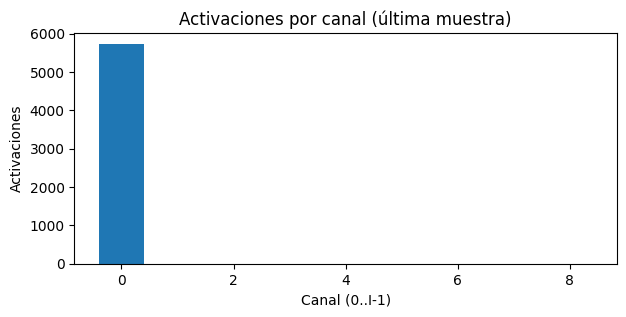

OUT_DIR: C:\Users\Djcho\Documents\Repositories\Polyrhythmia\model_lstm\outputs\2025-10-22\model3


In [36]:
from IPython.display import Audio, display
import matplotlib.pyplot as plt

GENRES = ["jazz","bossa","samba","hiphop","afrocubano","choro"]
NUM_SAMPLES_PER_GENRE = 3
TEMPERATURE = 1.0
TOP_K = 8
REST_IDS = {0}   # ajusta si tu token silencio es otro
BPM = 100

def bars_for_min_seconds(bpm: float, min_seconds=10.0) -> int:
    sec_per_bar = 60.0 / bpm * 4.0
    return max(1, int(math.ceil(min_seconds / sec_per_bar)))

BARS_PER_SAMPLE = bars_for_min_seconds(BPM, min_seconds=10.0)
print("BARS_PER_SAMPLE:", BARS_PER_SAMPLE)

wav_dir = OUT_DIR / "audio_wav"
wav_dir.mkdir(parents=True, exist_ok=True)

gm_notes = gm_map_for_I(I)

def style_vector_for(name:str, S:int) -> np.ndarray:
    idx = {"jazz":0,"bossa":1,"samba":2,"hiphop":3,"afrocubano":4,"choro":5}.get(name, 0)
    z = np.zeros((S,), dtype=np.float32)
    if 0<=idx<S: z[idx]=1.0
    return z

samples_meta = []
all_metrics = []

if density_expected.size != I:
    print(f"[WARN] density_expected.size={density_expected.size} != I={I} → padding/trimming aplicado")
if K_expected.size != I + 1:
    print(f"[WARN] K_expected.size={K_expected.size} != I+1={I+1} (recomputando)")
    K_expected = np.bincount(np.sum(M_ds > 0.5, axis=1), minlength=I+1)
    K_expected = K_expected / np.maximum(1, np.sum(K_expected))


for g in GENRES:
    kept, attempts = 0, 0
    print(f"\n== {g} ==")
    while kept < NUM_SAMPLES_PER_GENRE and attempts < NUM_SAMPLES_PER_GENRE*8:
        attempts += 1
        # estilo si el modelo lo acepta
        z = None
        if sig["style"] is not None:
            S = int(model.inputs[sig["style"]].shape[-1])
            z = style_vector_for(g, S)

        # genera varios compases y concatena
        bars_tokens = [generate_bar(model, T=T, top_k=TOP_K, temperature=TEMPERATURE, style_vec=z, rest_ids=REST_IDS)
                       for _ in range(BARS_PER_SAMPLE)]
        toks = np.concatenate(bars_tokens, axis=0)

        # tokens → multihot
        M = tokens_to_multihot(toks, id2bitmask, I)

        # métricas
        met = compute_metrics(M, density_expected, K_expected)
        accept = (met["density_L1"] < 0.35)  # umbral simple; ajusta si lo deseas

        if accept:
            fname = f"{g}_sample{kept+1:02d}_{BARS_PER_SAMPLE}bars_{BPM}bpm.wav"
            fpath = (wav_dir / fname)
            pm_obj = multihot_to_pretty_midi(M, bpm=BPM, gm_notes=gm_notes)
            t0 = time.time()
            write_wav_from_pretty_midi(pm_obj, SF2_PATH, fpath, sr=44100)
            dt = (time.time() - t0)*1000
            print(f" ✓ {fname} | dens_L1={met['density_L1']:.3f}  K_L1={met['K_L1']:.3f}  [sint={dt:.0f} ms]")
            display(Audio(filename=str(fpath)))

            samples_meta.append({"genre": g, "file": str(fpath)})
            all_metrics.append({"file": fname, **met})
            kept += 1
        else:
            print(f"   desc.: dens_L1={met['density_L1']:.3f}  K_L1={met['K_L1']:.3f}")

print("\nResumen:", samples_meta[:3], "... total=", len(samples_meta))

# Diagnóstico rápido: activaciones por canal (suma) con la última M generada si existe
if 'M' in locals():
    sums = M.sum(axis=0)
    plt.figure(figsize=(7,3))
    plt.bar(np.arange(I), sums)
    plt.title("Activaciones por canal (última muestra)")
    plt.xlabel("Canal (0..I-1)"); plt.ylabel("Activaciones")
    plt.show()

print("OUT_DIR:", OUT_DIR)
